# k-means clustering

In this notebook, we will experiment with k-means clustering, looking at cases when it succeeds and when it fails to work.

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

Below is a partial implementation of k-means, initialized with means chosen randomly from the input set (Forgy initialization). Essentially, the algorithm is as follows: `update_means`, then `assign_clusters`, repeated until the cluster assignments stabilize. `update_means` sets the mean of each cluster to be its centroid of each cluster, then `assign_cluster` clusters points based on the mean closest to them.

### Part (a)
**Finish the implementation of `update_means` and `assign_clusters`.**

In [2]:
def assign_clusters(data, means):
    """
    Takes in a n x d data matrix, and a k x d matrix of the means.
    Returns a length-n vector with the index of the closest mean to each data point.
    """
    n, d = data.shape
    k = means.shape[0]
    assert d == means.shape[1], "Means are of the wrong shape"
    out = np.zeros(n)
    for i, x in enumerate(data):
        # Set out[i] to be the cluster whose mean is closest to point x

        ### start assign_cluster ###
        # Calculate distances from point x to each mean
        distances = np.linalg.norm(means - x, axis=1)
        # Assign to the closest mean
        out[i] = np.argmin(distances)
        ### end assign_cluster ###
    return out

def update_means(data, clusters):
    """
    Takes in an n x d data matrix, and a length-n vector of the
    cluster indices of each point.
    Computes the mean of each cluster and returns a k x d matrix of the means.
    """
    n, d = data.shape
    assert len(clusters) == n
    k = len(set(clusters))
    cluster_means = []
    for i in range(k):
        # Set `cluster_mean` to be the mean of all points in cluster `i`
        # (Assume at least one such point exists)

        ### start update_means ###
        # Select all points belonging to cluster i
        cluster_points = data[clusters == i]
        # Calculate the mean of these points
        cluster_mean = np.mean(cluster_points, axis=0)
        ### end update_means ###
        cluster_means.append(cluster_mean)
    return np.array(cluster_means)

def cost(data, clusters, means):
    """
    Computes the sum of the squared distance between each point
    and the mean of its associated cluster
    """
    out = 0
    n, d = data.shape
    k = means.shape[0]
    assert means.shape[1] == d
    assert len(clusters) == n
    for i in range(k):
        out += np.linalg.norm(data[clusters == i] - means[i])
    return out

def k_means_cluster(data, k):
    """
    Takes in an n x d data matrix and parameter `k`.
    Yields the cluster means and cluster assignments after
    each step of running k-means, in a 2-tuple.
    """
    n, d = data.shape
    means = data[np.random.choice(n, k, replace=False)]
    assignments = assign_clusters(data, means)
    while True:
        yield means, assignments
        means = update_means(data, assignments)
        new_assignments = assign_clusters(data, means)
        if np.all(assignments == new_assignments):
            yield means, assignments
            print("Final cost = {}".format(cost(data, assignments, means)))
            break
        assignments = new_assignments

These are just some utility methods that will prove handy when conducting our experiments.

In [3]:
def final_k_means_cluster(data, k):
    out = list(k_means_cluster(data, k))
    return out[-1]

def plot_clustering(data, means, assignments, title="Predicted Clusters"):
    k = len(means)
    for j in range(k):
        plt.scatter(*data[assignments == j].T)
    plt.scatter(*means.T, marker="x", s=240, c="black")
    plt.title(title)
    plt.show()

def interact_clustering(data, logger):
    history = list(logger)
    k = history[0][0].shape[0]

    def plotter(i):
        plot_clustering(data, *history[i])

    interact(plotter, i=IntSlider(min=0, max=len(history) - 1, continuous_update=False))

def demo(classes, history=False):
    for c in classes:
        plt.scatter(*c.T)
    plt.title("Ground Truth Clusters")
    plt.show()

    points = np.vstack(classes)

    if history:
        interact_clustering(points, k_means_cluster(points, len(classes)))
    else:
        means, assignments = final_k_means_cluster(points, len(classes))
        plot_clustering(points, means, assignments)

### Part (b)
Now that you've completed your implementation, let's see k-means in action! First, we will generate some points from two isotropic Gaussian distributions, stacked together. Our goal will be for k-means to separate out the points from each distribution.

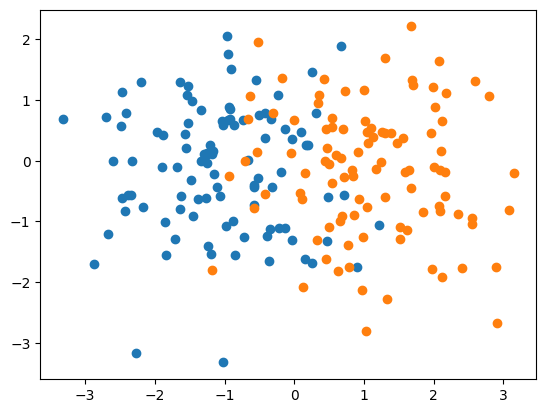

In [4]:
def gen_gaussian_points(n, mean, sigma):
    return np.random.normal(mean, sigma, [n, 2])

N = 100

class_a = gen_gaussian_points(N, [-1, 0], [1, 1])
class_b = gen_gaussian_points(N, [1, 0], [1, 1])

points = np.vstack([class_a, class_b])

plt.scatter(*class_a.T)
plt.scatter(*class_b.T)

The above points are reasonably well separated, but there is some overlap between the distributions. Now we will run k-means clustering on this (unlabeled) set of points, to see how well they are separated.

Run the below cell a couple of times and see how the clustering works. **Does the initial choice of means matter, in this case? What happens if we try to fit 3 or more clusters, or if we vary the spacing between the Gaussian means?**

In [35]:
interact_clustering(points, k_means_cluster(points, 3))

Final cost = 34.67978515068204


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=7), Output()), _dom_cla…

### start two-gaussians-comments ###
The initial means, the number of clusters chosen, and the spacing between data distributions all significantly influence K-means clustering results.

Initial Means: Affects convergence and accuracy.

Number of Clusters (k): More clusters than underlying distributions can lead to arbitrary splitting.

Spacing between Means: Greater spacing improves cluster separability; less spacing increases overlap and ambiguity.

### end two-gaussians-comments ###

### Part (c)
Above, we saw the "ideal" case of k-means, with reasonable well-separated clusters each drawn from isotropic Gaussians. Now we will look at some datasets with non-ideal properties, on which k-means performs poorly for various results.

One problem with k-means is that it can be sensitive to the initial choice of means. Below, we construct a dataset  with three equally spaced point sets of roughly equal size sampled from isotropic Gaussians, as well as a fourth point set slightly removed from the other three of a smaller size.

**Run the below cell a few times. Does k-means always succesfully separate the four classes of points as you'd expect?**

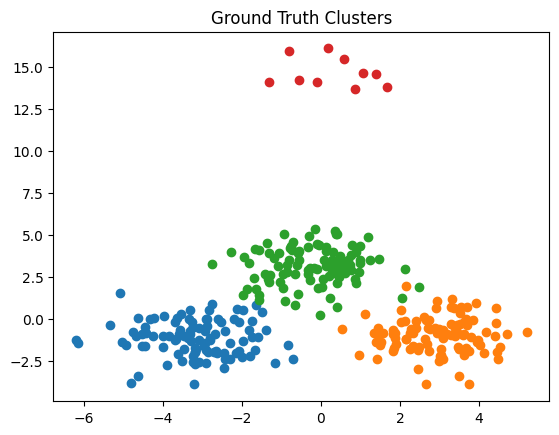

Final cost = 47.48274737551056


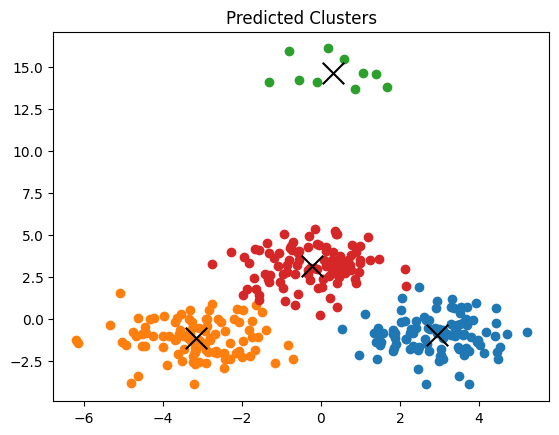

In [39]:
class_a = gen_gaussian_points(N, [-3, -1], [1, 1])
class_b = gen_gaussian_points(N, [3, -1], [1, 1])
class_c = gen_gaussian_points(N, [0, 3], [1, 1])
class_d = gen_gaussian_points(10, [0, 15], [1, 1])


demo([class_a, class_b, class_c, class_d], history=False) # consider changing this to history=True

You should see that in some cases, k-means fails to separate the four groups into their original four distributions. What does it do instead? Why is this the case? How does this affect the cost of the final clustering? **Comment on your observations.** (Consider passing the `history=True` flag into the call to `demo` above, to see the iterations of k-means as it separates the points.)

### start four-clusters ###
K-means often fails to separate the four clusters in this dataset due to the proximity of three dense clusters (class_a, class_b, class_c) and the presence of a distant, smaller outlier cluster (class_d). The algorithm sometimes merges two of the closer clusters, resulting in only three clusters, because this configuration can reduce the overall cost (sum of squared distances) more than accurately identifying all four groups. This occurs because K-means prioritizes minimizing distances within clusters over matching the true distribution, especially when initial centroids are randomly placed. The isolated class_d cluster is usually identified correctly due to its distance from the others, but the dense clusters often merge depending on the initialization, highlighting K-means’ sensitivity to initial centroids and its limitations with imbalanced, overlapping clusters. In this case, the final clustering cost can be misleadingly low, as it does not necessarily reflect the ideal separation of the true groups.
### end four-clusters ###

### Part (d)
We next consider an example with three clusters spaced on the x-axis. You should see that k-means does a reasonable job of separating the clusters, at least visually. Now look at the exact output of the algorithm. In particular, look at the estimated cluster means that it returns.  **How do they compare to the actual means of the true distribution of each cluster? Justify this difference. Will it affect the classification of a new test point?**

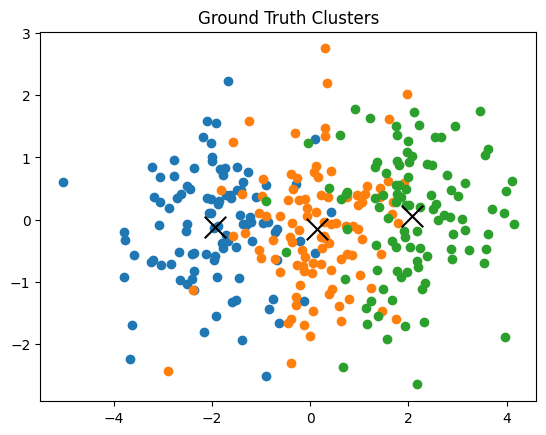

Final cost = 34.679244255343804


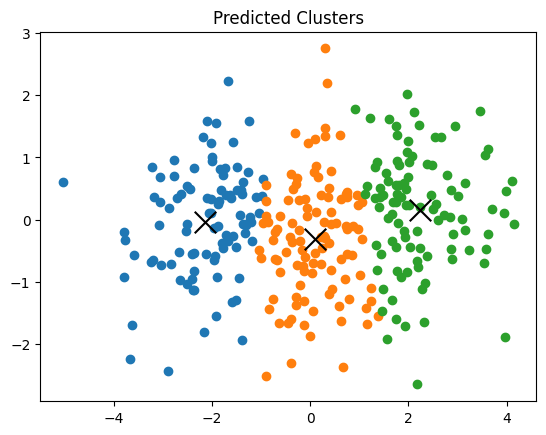

Ground Truth Means [[-1.93672677 -0.11854243]
 [ 0.13689387 -0.15430931]
 [ 2.07960841  0.06245176]]
Predicted Means [[-2.13624904 -0.03609905]
 [ 0.09151601 -0.3073126 ]
 [ 2.23455064  0.15115704]]


In [24]:
class_a = gen_gaussian_points(N, [-2, 0], [1, 1])
class_b = gen_gaussian_points(N, [0, 0], [1, 1])
class_c = gen_gaussian_points(N, [2, 0], [1, 1])

points = np.vstack([class_a, class_b, class_c])

gt_means = [np.mean(cluster, axis=0) for cluster in [class_a, class_b, class_c]]
gt_means = np.stack(gt_means)
gt_assignments = np.array([0] * N + [1] * N + [2] * N)
plot_clustering(points, gt_means, gt_assignments, "Ground Truth Clusters")

means, assignments = final_k_means_cluster(points, 3)
plot_clustering(points, means, assignments, "Predicted Clusters")

print("Ground Truth Means", gt_means)
print("Predicted Means", means)

### start cluster-means ###
In this example, K-means manages to separate the clusters fairly well, given their distinct locations along the x-axis. However, the predicted cluster means slightly deviate from the true means of each distribution. This difference arises because K-means minimizes the sum of squared distances within clusters rather than estimating parameters to match the true data distribution precisely. K-means only approximates the cluster centroids based on data points assigned to each cluster, which may result in centroids that are close but not identical to the actual Gaussian means, especially if there is overlap or variation within each cluster.

This discrepancy in means should have a minimal impact on classifying a new test point if it is positioned closer to one of the cluster centers, as the point will still likely be assigned to the nearest centroid. However, for test points that fall near the boundaries between clusters, these small shifts in centroid positions could lead to different cluster assignments than if the actual distribution means were used. In general, though, the effect is minor in well-separated clusters like these.
### end cluster-means ###

### Part (e)
Now, we will look at what happens when our Gaussians are no longer isotropic, so they have much greater variance in one dimension versus another. Below, we generate two very well separated clusters, but that have high variance in the y-dimension compared to the x-dimension. **Comment on what happens when we apply k-means to cluster them.**

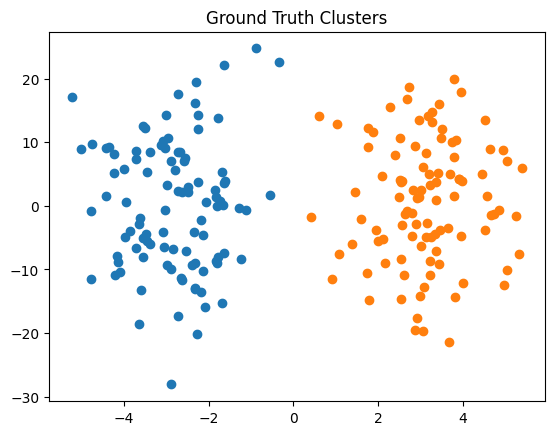

Final cost = 128.40881104665496


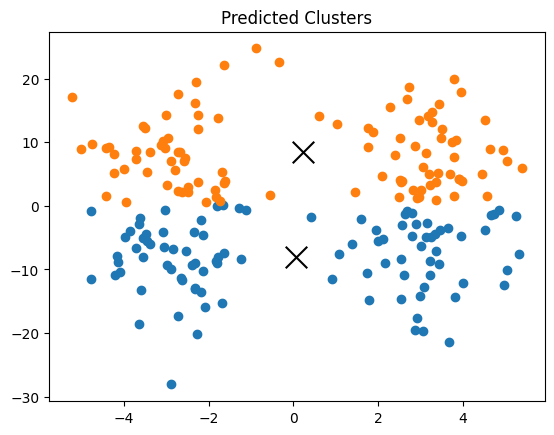

In [40]:
# what happens if the Gaussians are not isotropic?
RESCALE_DATA = False

class_a = gen_gaussian_points(N, [-3, 0], [1, 10])
class_b = gen_gaussian_points(N, [3, 0], [1, 10])
demo([class_a, class_b])

**Can you justify what's going on? Qualitatively, why might a Gaussian Mixture Model perform better in this setting? \\
(Saying "because the data comes from a Gaussian distribution" is not a valid answer. You should speak about the anisotropy of the clusters specifically.)**

### start anisotropic-observations ###
In this example, K-means struggles to cluster the data correctly because the clusters are anisotropic, having high variance along the y-axis and lower variance along the x-axis. K-means assumes that clusters are roughly circular (isotropic) in all directions and minimizes the sum of squared distances, so it positions centroids in a way that attempts to split the data based on proximity in all dimensions equally. As a result, the centroids are placed between the two clusters along the x-axis but do not account for the elongated spread of points along the y-axis. Consequently, K-means ends up dividing the clusters horizontally rather than capturing their true vertical spread.

A Gaussian Mixture Model (GMM) with an anisotropic covariance structure would perform better here because it can model clusters with different variances along different dimensions, fitting ellipsoidal shapes rather than circular ones. GMMs allow each component to have its own covariance matrix, which would enable it to capture the high variance in the y-dimension separately from the x-dimension. This flexibility would result in cluster assignments that better match the actual spread and orientation of the data, effectively capturing the natural structure of the clusters.
### end anisotropic-observations ###